# Demo: Fitting a sine curve

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="multiprocessing.resource_tracker")

import numpy as np
import matplotlib.pyplot as plt

import nbi

In [2]:
print(nbi.__version__)

0.4.1


This notebook provides a minimal example that could be used as a template to adapt to your specific tasks.

Let us consider a very simple sine curve model, where $t$ is time, $\omega$ is angular frequency, $A$ is amplitude, and $\phi_0$ is initial phase:<br>
$f(t) = A\cdot\sin(\omega\cdot t+\phi_0$)

Assume parameters from the following uniform distribution:<br>
$\phi_0\in[0,2\pi]$, $A\in[-4,4]$, $\omega\in[2\pi,12\pi]$

Note that the amplitude is allowed to be negative. Thus expect bi-modal posteriors in the amplitude.

Also assume Gaussian measurement noise fixed to be $\sigma_0$:<br>
$x_{\rm obs}\sim N(f(t), \sigma=\sigma_0)$

In [3]:
t = np.linspace(0,1,50)
def sine(param):
    phi0, A, omega = param
    return np.sin(omega * t + phi0) * A

In [4]:
# nbi requires prior to be defined with scipy functions
# alternatively, you may supply pre-generated parameters with numpy arrays

from scipy.stats import uniform, truncnorm
prior = {
    'phi0': uniform(loc=0, scale=np.pi*2),
    'A': uniform(loc=-4, scale=8),
    'omega': uniform(loc=2*np.pi, scale=10*np.pi)
}
labels = list(prior.keys())
priors = [prior[k] for k in labels]

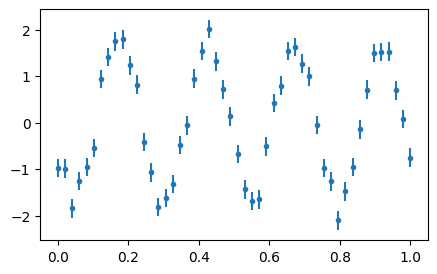

In [5]:
# a randomly drawn sine curve for illustration

plt.figure(figsize=(5,3))
np.random.seed(0)

# draw random parameter from prior
y_true = [var.rvs(1)[0] for var in priors]

# add fixed gaussian noise of 1
x_err = 0.2
x_obs = sine(y_true) + np.random.normal(size=50) * x_err

plt.errorbar(t, x_obs, yerr=x_err, fmt='.')
plt.show()

## Use case 1: Amortized Neural Posterior Estimation
if we want to derive the posterior for a large number of different x_obs, then train nbi for 1 round on a large number of samples generated from the prior.

In [6]:
# the noise function can include any component of the forward model that is cheap
# therefore it takes in both data (x) and parameter (y) as input
# Here let us only consider iid Gaussian noise

def noise(x, y):
    rand = np.random.normal(0, 1, size=x.shape[0])
    
    # let's say x_err is drawn from [0.05, 0.5]
    x_err = np.random.uniform() * 0.45 + 0.05
    x_noise = x + rand * x_err
    return x_noise, y

In [7]:
# hyperparameters for the normalizing flow
flow = {
    'n_dims': 3,              # dimension of parameter space
    'flow_hidden': 128,
    'num_blocks': 5,
    'n_mog':4                # Number of Mixture of Gaussian as base density
}

# the NBI package provides the "ResNet-GRU" network as the default
# featurizer network for sequential data
featurizer = {
    'type': 'resnet-gru',
    'norm': 'weight_norm',
    'dim_in': 1,              # Number of channels for input data
    'dim_out': 128,            # Output feature vector dimension
    'dim_conv_max': 256,      # Maximum hidden dimension for CNN
    'depth': 3                # Number of 1D ResNet layers
}

# initialize NBI engine
engine = nbi.NBI(
    flow=flow,
    featurizer=featurizer,
    simulator=sine,
    priors=priors,
    labels=labels,
    device='cpu',
    path='test2',
    n_jobs=10
)

In [8]:
engine.fit(
    n_sims=12800,
    n_rounds=1,
    n_epochs=300,
    batch_size=512,
    lr=0.001,
    early_stop_patience=250,
    noise=noise  # this can also be an array if fixed noise
)

Auto learning rate to min_lr = 1.3333333333333334e-06
Generating simulations


1280it [00:00, 2693.36it/s]
/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.


---------------------- Round: 0 ----------------------


Epoch 0: Train, Loglike in nats: -3.851653:  98%|▉| 11264/11520 [00:02<00:00
- Val, Loglike in nats: -2.984723:  80%|▊| 1024/1280 [00:00<00:00, 2999.58it
Epoch 1: Train, Loglike in nats: -2.498076:  98%|▉| 11264/11520 [00:02<00:00
- Val, Loglike in nats: -2.240993:  80%|▊| 1024/1280 [00:00<00:00, 3671.05it
Epoch 2: Train, Loglike in nats: -2.853344:  98%|▉| 11264/11520 [00:04<00:00
- Val, Loglike in nats: -2.363469:  80%|▊| 1024/1280 [00:00<00:00, 8830.57it
Epoch 3: Train, Loglike in nats: -2.240685:  98%|▉| 11264/11520 [00:03<00:00
- Val, Loglike in nats: -1.919772:  80%|▊| 1024/1280 [00:00<00:00, 8462.06it
Epoch 4: Train, Loglike in nats: -1.620814:  98%|▉| 11264/11520 [00:02<00:00
- Val, Loglike in nats: -1.600617:  80%|▊| 1024/1280 [00:00<00:00, 9509.40it
Epoch 5: Train, Loglike in nats: -1.647011:  98%|▉| 11264/11520 [00:03<00:00
- Val, Loglike in nats: -1.350998:  80%|▊| 1024/1280 [00:00<00:00, 9575.18it
Epoch 6: Train, Loglike in nats: -1.284166:  98%|▉| 11264/11520 [00:02<00:00

Epoch 53: Train, Loglike in nats: 4.444990:  98%|▉| 11264/11520 [00:02<00:00
- Val, Loglike in nats: 4.276281:  80%|▊| 1024/1280 [00:00<00:00, 9887.60it/
Epoch 54: Train, Loglike in nats: 3.256611:  98%|▉| 11264/11520 [00:02<00:00
- Val, Loglike in nats: 3.587253:  80%|▊| 1024/1280 [00:00<00:00, 9367.15it/
Epoch 55: Train, Loglike in nats: 4.213576:  98%|▉| 11264/11520 [00:03<00:00
- Val, Loglike in nats: 4.282850:  80%|▊| 1024/1280 [00:00<00:00, 9826.30it/
Epoch 56: Train, Loglike in nats: 3.593654:  98%|▉| 11264/11520 [00:02<00:00
- Val, Loglike in nats: 3.533817:  80%|▊| 1024/1280 [00:00<00:00, 8401.16it/
Epoch 57: Train, Loglike in nats: 4.071354:  98%|▉| 11264/11520 [00:02<00:00
- Val, Loglike in nats: 4.336431:  80%|▊| 1024/1280 [00:00<00:00, 9924.11it/
Epoch 58: Train, Loglike in nats: 4.523057:  98%|▉| 11264/11520 [00:02<00:00
- Val, Loglike in nats: 4.639695:  80%|▊| 1024/1280 [00:00<00:00, 9383.29it/
Epoch 59: Train, Loglike in nats: 4.584000:  98%|▉| 11264/11520 [00:03<00:00

Epoch 106: Train, Loglike in nats: 4.637647:  98%|▉| 11264/11520 [00:03<00:0
- Val, Loglike in nats: 5.023439:  80%|▊| 1024/1280 [00:00<00:00, 3347.82it/
Epoch 107: Train, Loglike in nats: 5.183452:  98%|▉| 11264/11520 [00:02<00:0
- Val, Loglike in nats: 4.972174:  80%|▊| 1024/1280 [00:00<00:00, 9162.91it/
Epoch 108: Train, Loglike in nats: 5.198407:  98%|▉| 11264/11520 [00:02<00:0
- Val, Loglike in nats: 5.045882:  80%|▊| 1024/1280 [00:00<00:00, 9146.85it/
Epoch 109: Train, Loglike in nats: 5.246219:  98%|▉| 11264/11520 [00:03<00:0
- Val, Loglike in nats: 5.143646:  80%|▊| 1024/1280 [00:00<00:00, 8695.50it/
Epoch 110: Train, Loglike in nats: 5.315694:  98%|▉| 11264/11520 [00:03<00:0
- Val, Loglike in nats: 5.255485:  80%|▊| 1024/1280 [00:00<00:00, 9071.33it/
Epoch 111: Train, Loglike in nats: 5.331820:  98%|▉| 11264/11520 [00:03<00:0
- Val, Loglike in nats: 4.875888:  80%|▊| 1024/1280 [00:00<00:00, 8933.55it/
Epoch 112: Train, Loglike in nats: 5.283599:  98%|▉| 11264/11520 [00:02<00:0

Epoch 159: Train, Loglike in nats: 5.649284:  98%|▉| 11264/11520 [00:02<00:0
- Val, Loglike in nats: 5.628625:  80%|▊| 1024/1280 [00:00<00:00, 9511.76it/
Epoch 160: Train, Loglike in nats: 5.646411:  98%|▉| 11264/11520 [00:02<00:0
- Val, Loglike in nats: 5.577348:  80%|▊| 1024/1280 [00:00<00:00, 9199.28it/
Epoch 161: Train, Loglike in nats: 5.624748:  98%|▉| 11264/11520 [00:02<00:0
- Val, Loglike in nats: 5.624774:  80%|▊| 1024/1280 [00:00<00:00, 4714.98it/
Epoch 162: Train, Loglike in nats: 5.749968:  98%|▉| 11264/11520 [00:03<00:0
- Val, Loglike in nats: 5.792416:  80%|▊| 1024/1280 [00:00<00:00, 9005.11it/
Epoch 163: Train, Loglike in nats: 5.768485:  98%|▉| 11264/11520 [00:02<00:0
- Val, Loglike in nats: 5.791962:  80%|▊| 1024/1280 [00:00<00:00, 9167.66it/
Epoch 164: Train, Loglike in nats: 5.813198:  98%|▉| 11264/11520 [00:02<00:0
- Val, Loglike in nats: 5.494507:  80%|▊| 1024/1280 [00:00<00:00, 9091.55it/
Epoch 165: Train, Loglike in nats: 5.487433:  98%|▉| 11264/11520 [00:02<00:0

Epoch 212: Train, Loglike in nats: 6.098628:  98%|▉| 11264/11520 [00:03<00:0
- Val, Loglike in nats: 6.035763:  80%|▊| 1024/1280 [00:00<00:00, 8962.71it/
Epoch 213: Train, Loglike in nats: 6.042898:  98%|▉| 11264/11520 [00:03<00:0
- Val, Loglike in nats: 6.003551:  80%|▊| 1024/1280 [00:00<00:00, 6201.92it/
Epoch 214: Train, Loglike in nats: 6.053481:  98%|▉| 11264/11520 [00:03<00:0
- Val, Loglike in nats: 5.963653:  80%|▊| 1024/1280 [00:00<00:00, 8837.71it/
Epoch 215: Train, Loglike in nats: 6.071988:  98%|▉| 11264/11520 [00:02<00:0
- Val, Loglike in nats: 5.977085:  80%|▊| 1024/1280 [00:00<00:00, 8339.86it/
Epoch 216: Train, Loglike in nats: 6.081740:  98%|▉| 11264/11520 [00:03<00:0
- Val, Loglike in nats: 5.977153:  80%|▊| 1024/1280 [00:00<00:00, 9069.59it/
Epoch 217: Train, Loglike in nats: 6.076434:  98%|▉| 11264/11520 [00:02<00:0
- Val, Loglike in nats: 5.990683:  80%|▊| 1024/1280 [00:00<00:00, 8634.58it/
Epoch 218: Train, Loglike in nats: 6.065740:  98%|▉| 11264/11520 [00:03<00:0

Epoch 265: Train, Loglike in nats: 6.240774:  98%|▉| 11264/11520 [00:02<00:0
- Val, Loglike in nats: 6.130541:  80%|▊| 1024/1280 [00:00<00:00, 9059.14it/
Epoch 266: Train, Loglike in nats: 6.258704:  98%|▉| 11264/11520 [00:02<00:0
- Val, Loglike in nats: 6.134007:  80%|▊| 1024/1280 [00:00<00:00, 8928.99it/
Epoch 267: Train, Loglike in nats: 6.240042:  98%|▉| 11264/11520 [00:02<00:0
- Val, Loglike in nats: 6.201356:  80%|▊| 1024/1280 [00:00<00:00, 3442.43it/
Epoch 268: Train, Loglike in nats: 6.225747:  98%|▉| 11264/11520 [00:02<00:0
- Val, Loglike in nats: 6.070212:  80%|▊| 1024/1280 [00:00<00:00, 9378.93it/
Epoch 269: Train, Loglike in nats: 6.202410:  98%|▉| 11264/11520 [00:02<00:0
- Val, Loglike in nats: 6.229268:  80%|▊| 1024/1280 [00:00<00:00, 8724.09it/
Epoch 270: Train, Loglike in nats: 6.238284:  98%|▉| 11264/11520 [00:02<00:0
- Val, Loglike in nats: 6.154505:  80%|▊| 1024/1280 [00:00<00:00, 8554.72it/
Epoch 271: Train, Loglike in nats: 6.255405:  98%|▉| 11264/11520 [00:02<00:0

Now we can apply the trained model to derive the model posterior for any sine curve. Nbi uses importance sampling to deliver asymptotically exact results if you specify x_err in engine.predict().

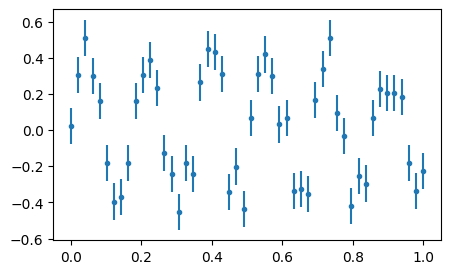

Samples outside prior N = 1512
surrogate posterior


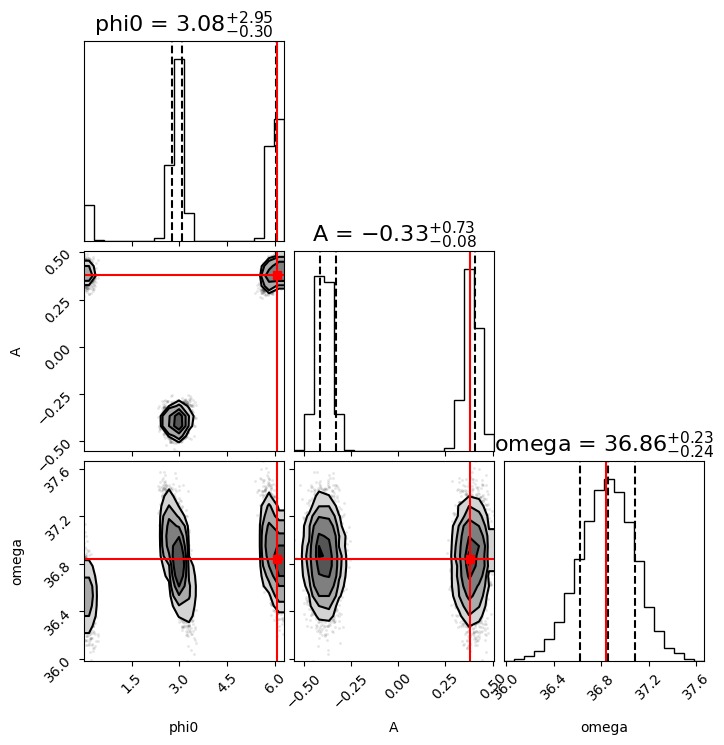

Generating simulations


1129it [00:00, 2181.67it/s]


Effective Sample Size = 2656.2
Sampling efficiency = 20.8%


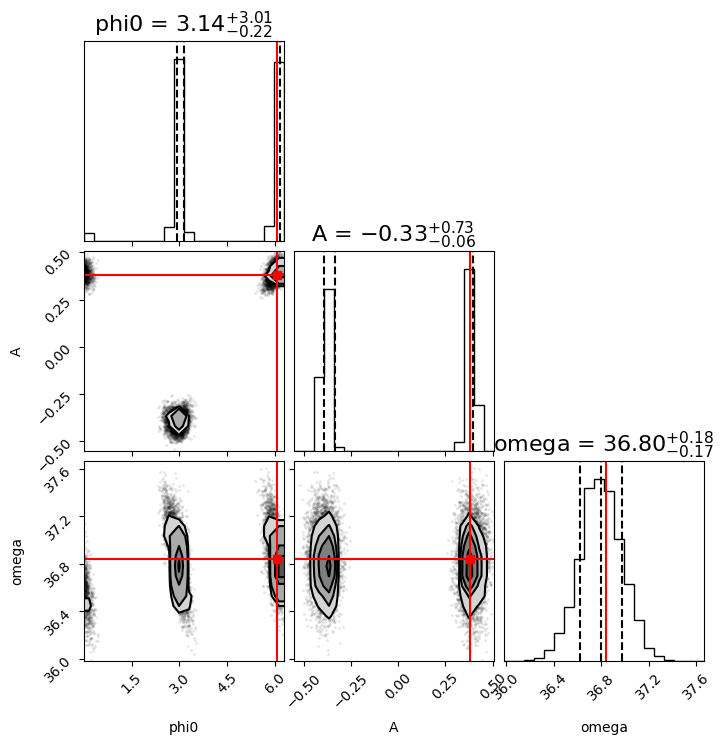

In [16]:
plt.figure(figsize=(5,3))
np.random.seed(4)

# draw random parameter from prior
y_true = [var.rvs(1)[0] for var in priors]
x_err = 0.1
x_obs = sine(y_true) + np.random.normal(size=50) * x_err
plt.errorbar(t, x_obs, yerr=x_err, fmt='.')
plt.show()

y_pred, weights = engine.predict(x_obs, x_err=np.array([0.1]*50), y_true=y_true, n_samples=12800, corner=True, corner_reweight=True,seed=0)
plt.show()

In [14]:
# You can now easily distribute the trained model by sending the best checkpoint:
best_model = engine.best_params
print('Best model checkpoint is saved to:', best_model)

Best model checkpoint is saved to: test2/0/299.pth


In [17]:
# Others can easily load the trained model for inference using the state_dict parameter
# Since the state_dict contains the network hyperparameters, no need to supply flow and featurizer dictionaries
engine_loaded = nbi.NBI(
    state_dict=best_model,
    simulator=sine,
    priors=priors,
    labels=labels,
    device='cpu',
    path='test2',
    n_jobs=10
)
y_pred2, weights2 = engine_loaded.predict(x_obs, x_err=np.array([0.1]*50), y_true=y_true, n_samples=12800, seed=0)

Samples outside prior N = 1512
Generating simulations


1129it [00:00, 2437.05it/s]


Effective Sample Size = 2656.2
Sampling efficiency = 20.8%


In [19]:
# the loaded model produces the identical result
np.allclose(y_pred2,y_pred)

True

## Use case 2: Sequential Neural Posterior Estimation (SNPE)
Let's say we only want to fit the specific sine curve above.

In this case, we can specify n_rounds > 1 to train the model over multiple rounds to reduce the number of training samples required. The basic idea is to generate more training samples near the final posterior (as opposed to the broad prior).

In [8]:
# hyperparameters remain the same as ANPE
flow = {
    'n_dims': 3,              # dimension of parameter space
    'flow_hidden': 128,
    'num_blocks': 5,
    'n_mog':4
}

# the NBI package provides the "ResNet-GRU" network as the default
# featurizer network for sequential data
featurizer = {
    'type': 'resnet-gru',
    'norm': 'weight_norm',
    'dim_in': 1,
    'dim_out': 128,
    'dim_conv_max': 256,
    'depth': 3
}

# initializtion is teh same with ANPE
engine = nbi.NBI(
    flow=flow,
    featurizer=featurizer,
    simulator=sine,
    priors=priors,
    labels=labels,
    path='test',
    device='cpu',
    n_jobs=10,
)

Auto learning rate to min_lr = 8.333333333333333e-07
Generating simulations


256it [00:00, 2883.50it/s]


Effective sample size for current/all rounds 0.0/0.0

---------------------- Round: 0 ----------------------


Epoch 0: Train, Loglike in nats: -3.268526: 100%|█| 2304/2304 [00:00<00:00, 
- Val, Loglike in nats: -2.459209: 100%|█| 256/256 [00:00<00:00, 1261.47it/s
Epoch 1: Train, Loglike in nats: -2.159331: 100%|█| 2304/2304 [00:01<00:00, 
- Val, Loglike in nats: -1.682208: 100%|█| 256/256 [00:00<00:00, 5980.08it/s
Epoch 2: Train, Loglike in nats: -1.848469: 100%|█| 2304/2304 [00:00<00:00, 
- Val, Loglike in nats: -1.720842: 100%|█| 256/256 [00:00<00:00, 5995.34it/s
Epoch 3: Train, Loglike in nats: -1.418813: 100%|█| 2304/2304 [00:00<00:00, 
- Val, Loglike in nats: -1.714325: 100%|█| 256/256 [00:00<00:00, 2912.96it/s
Epoch 4: Train, Loglike in nats: -1.574528: 100%|█| 2304/2304 [00:00<00:00, 
- Val, Loglike in nats: -1.149077: 100%|█| 256/256 [00:00<00:00, 6075.26it/s
Epoch 5: Train, Loglike in nats: -1.042438: 100%|█| 2304/2304 [00:00<00:00, 
- Val, Loglike in nats: -0.894966: 100%|█| 256/256 [00:00<00:00, 6068.22it/s
Epoch 6: Train, Loglike in nats: -1.492501: 100%|█| 2304/2304 [00:01<00:00, 

Epoch 53: Train, Loglike in nats: 3.714629: 100%|█| 2304/2304 [00:01<00:00, 
- Val, Loglike in nats: 3.687727: 100%|█| 256/256 [00:00<00:00, 6390.10it/s]
Epoch 54: Train, Loglike in nats: 3.723377: 100%|█| 2304/2304 [00:00<00:00, 
- Val, Loglike in nats: 3.727478: 100%|█| 256/256 [00:00<00:00, 6687.23it/s]
Epoch 55: Train, Loglike in nats: 3.166823: 100%|█| 2304/2304 [00:01<00:00, 
- Val, Loglike in nats: 1.733759: 100%|█| 256/256 [00:00<00:00, 6281.76it/s]
Epoch 56: Train, Loglike in nats: 3.368278: 100%|█| 2304/2304 [00:00<00:00, 
- Val, Loglike in nats: 3.668584: 100%|█| 256/256 [00:00<00:00, 6511.99it/s]
Epoch 57: Train, Loglike in nats: 3.880386: 100%|█| 2304/2304 [00:00<00:00, 
- Val, Loglike in nats: 4.082314: 100%|█| 256/256 [00:00<00:00, 6652.96it/s]
Epoch 58: Train, Loglike in nats: 4.114445: 100%|█| 2304/2304 [00:01<00:00, 
- Val, Loglike in nats: 4.050641: 100%|█| 256/256 [00:00<00:00, 6616.19it/s]
Epoch 59: Train, Loglike in nats: 3.763349: 100%|█| 2304/2304 [00:00<00:00, 

Epoch 106: Train, Loglike in nats: 5.917760: 100%|█| 2304/2304 [00:01<00:00,
- Val, Loglike in nats: 5.658114: 100%|█| 256/256 [00:00<00:00, 5785.68it/s]
Epoch 107: Train, Loglike in nats: 5.942582: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 5.720334: 100%|█| 256/256 [00:00<00:00, 6181.20it/s]
Epoch 108: Train, Loglike in nats: 6.048959: 100%|█| 2304/2304 [00:01<00:00,
- Val, Loglike in nats: 6.026139: 100%|█| 256/256 [00:00<00:00, 5834.19it/s]
Epoch 109: Train, Loglike in nats: 6.068287: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 5.803365: 100%|█| 256/256 [00:00<00:00, 6333.15it/s]
Epoch 110: Train, Loglike in nats: 5.634220: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.819095: 100%|█| 256/256 [00:00<00:00, 6168.09it/s]
Epoch 111: Train, Loglike in nats: 5.769787: 100%|█| 2304/2304 [00:01<00:00,
- Val, Loglike in nats: 5.741638: 100%|█| 256/256 [00:00<00:00, 6521.32it/s]
Epoch 112: Train, Loglike in nats: 5.882873: 100%|█| 2304/2304 [00:00<00:00,

Epoch 159: Train, Loglike in nats: 6.558365: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 6.334709: 100%|█| 256/256 [00:00<00:00, 6423.78it/s]
Epoch 160: Train, Loglike in nats: 6.552215: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 6.399486: 100%|█| 256/256 [00:00<00:00, 6294.91it/s]
Epoch 161: Train, Loglike in nats: 6.655611: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 6.340299: 100%|█| 256/256 [00:00<00:00, 6637.46it/s]
Epoch 162: Train, Loglike in nats: 6.651125: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 6.579459: 100%|█| 256/256 [00:00<00:00, 6802.21it/s]
Epoch 163: Train, Loglike in nats: 6.688755: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 6.509596: 100%|█| 256/256 [00:00<00:00, 6130.66it/s]
Epoch 164: Train, Loglike in nats: 6.641705: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 6.578617: 100%|█| 256/256 [00:00<00:00, 6181.59it/s]
Epoch 165: Train, Loglike in nats: 6.652033: 100%|█| 2304/2304 [00:01<00:00,

Epoch 212: Train, Loglike in nats: 7.128048: 100%|█| 2304/2304 [00:01<00:00,
- Val, Loglike in nats: 6.849624: 100%|█| 256/256 [00:00<00:00, 4464.29it/s]
Epoch 213: Train, Loglike in nats: 7.143510: 100%|█| 2304/2304 [00:01<00:00,
- Val, Loglike in nats: 6.848959: 100%|█| 256/256 [00:00<00:00, 3617.30it/s]
Epoch 214: Train, Loglike in nats: 7.088161: 100%|█| 2304/2304 [00:01<00:00,
- Val, Loglike in nats: 6.936358: 100%|█| 256/256 [00:00<00:00, 5338.33it/s]
Epoch 215: Train, Loglike in nats: 7.116961: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 6.940352: 100%|█| 256/256 [00:00<00:00, 4689.83it/s]
Epoch 216: Train, Loglike in nats: 7.121807: 100%|█| 2304/2304 [00:01<00:00,
- Val, Loglike in nats: 6.835408: 100%|█| 256/256 [00:00<00:00, 5121.86it/s]
Epoch 217: Train, Loglike in nats: 7.098231: 100%|█| 2304/2304 [00:01<00:00,
- Val, Loglike in nats: 6.857529: 100%|█| 256/256 [00:00<00:00, 4665.74it/s]
Epoch 218: Train, Loglike in nats: 7.107583: 100%|█| 2304/2304 [00:00<00:00,

Epoch 265: Train, Loglike in nats: 7.304676: 100%|█| 2304/2304 [00:01<00:00,
- Val, Loglike in nats: 7.008645: 100%|█| 256/256 [00:00<00:00, 3489.73it/s]
Epoch 266: Train, Loglike in nats: 7.279627: 100%|█| 2304/2304 [00:01<00:00,
- Val, Loglike in nats: 7.096175: 100%|█| 256/256 [00:00<00:00, 3291.83it/s]
Epoch 267: Train, Loglike in nats: 7.292471: 100%|█| 2304/2304 [00:01<00:00,
- Val, Loglike in nats: 7.023993: 100%|█| 256/256 [00:00<00:00, 4433.65it/s]
Epoch 268: Train, Loglike in nats: 7.318467: 100%|█| 2304/2304 [00:01<00:00,
- Val, Loglike in nats: 7.014885: 100%|█| 256/256 [00:00<00:00, 2584.37it/s]
Epoch 269: Train, Loglike in nats: 7.307246: 100%|█| 2304/2304 [00:01<00:00,
- Val, Loglike in nats: 7.107642: 100%|█| 256/256 [00:00<00:00, 3373.40it/s]
Epoch 270: Train, Loglike in nats: 7.321354: 100%|█| 2304/2304 [00:01<00:00,
- Val, Loglike in nats: 7.015020: 100%|█| 256/256 [00:00<00:00, 3856.87it/s]
Epoch 271: Train, Loglike in nats: 7.330850: 100%|█| 2304/2304 [00:01<00:00,

Generating simulations


256it [00:00, 3311.77it/s]


Effective sample size for current/all rounds 41.5/41.5


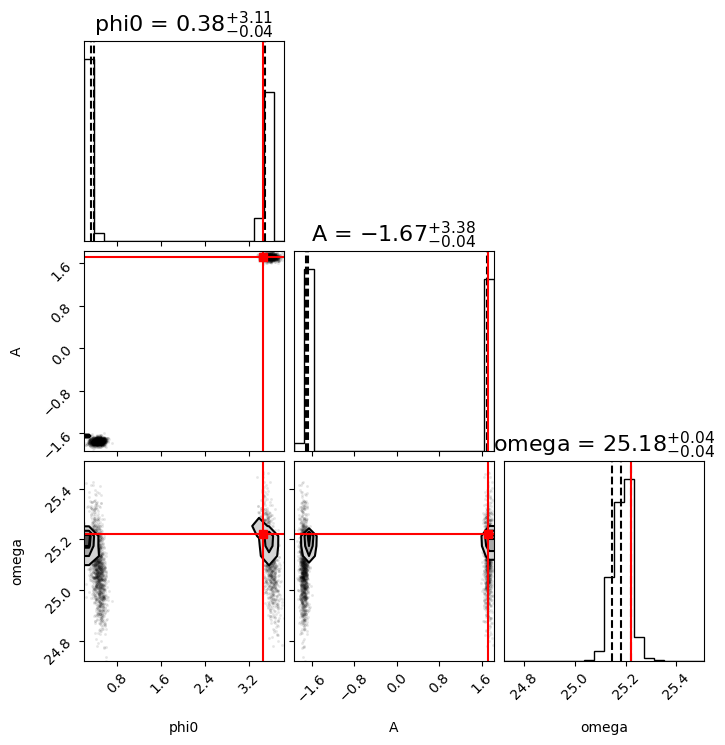


---------------------- Round: 1 ----------------------


Epoch 0: Train, Loglike in nats: -111.074880: 100%|█| 2304/2304 [00:01<00:00
- Val, Loglike in nats: -2.992713: 100%|█| 256/256 [00:00<00:00, 1011.96it/s
Epoch 1: Train, Loglike in nats: -2.200279: 100%|█| 2304/2304 [00:01<00:00, 
- Val, Loglike in nats: -1.263758: 100%|█| 256/256 [00:00<00:00, 2931.44it/s
Epoch 2: Train, Loglike in nats: -0.458073: 100%|█| 2304/2304 [00:01<00:00, 
- Val, Loglike in nats: 0.593628: 100%|█| 256/256 [00:00<00:00, 1573.11it/s]
Epoch 3: Train, Loglike in nats: 0.448375: 100%|█| 2304/2304 [00:01<00:00, 1
- Val, Loglike in nats: 1.122143: 100%|█| 256/256 [00:00<00:00, 2982.33it/s]
Epoch 4: Train, Loglike in nats: 0.888271: 100%|█| 2304/2304 [00:01<00:00, 1
- Val, Loglike in nats: 1.288034: 100%|█| 256/256 [00:00<00:00, 5056.57it/s]
Epoch 5: Train, Loglike in nats: 1.180175: 100%|█| 2304/2304 [00:01<00:00, 1
- Val, Loglike in nats: 1.176789: 100%|█| 256/256 [00:00<00:00, 1636.73it/s]
Epoch 6: Train, Loglike in nats: 0.437039: 100%|█| 2304/2304 [00:01<00:00, 1

Epoch 53: Train, Loglike in nats: 3.671081: 100%|█| 2304/2304 [00:00<00:00, 
- Val, Loglike in nats: 4.016607: 100%|█| 256/256 [00:00<00:00, 7086.66it/s]
Epoch 54: Train, Loglike in nats: 3.971538: 100%|█| 2304/2304 [00:00<00:00, 
- Val, Loglike in nats: 4.120502: 100%|█| 256/256 [00:00<00:00, 6758.15it/s]
Epoch 55: Train, Loglike in nats: 3.898712: 100%|█| 2304/2304 [00:00<00:00, 
- Val, Loglike in nats: 3.700991: 100%|█| 256/256 [00:00<00:00, 6854.84it/s]
Epoch 56: Train, Loglike in nats: 3.712658: 100%|█| 2304/2304 [00:00<00:00, 
- Val, Loglike in nats: 3.855739: 100%|█| 256/256 [00:00<00:00, 6845.83it/s]
Epoch 57: Train, Loglike in nats: 3.984127: 100%|█| 2304/2304 [00:00<00:00, 
- Val, Loglike in nats: 4.148764: 100%|█| 256/256 [00:00<00:00, 7051.10it/s]
Epoch 58: Train, Loglike in nats: 4.120578: 100%|█| 2304/2304 [00:00<00:00, 
- Val, Loglike in nats: 4.072963: 100%|█| 256/256 [00:00<00:00, 7087.12it/s]
Epoch 59: Train, Loglike in nats: 4.048295: 100%|█| 2304/2304 [00:00<00:00, 

Epoch 106: Train, Loglike in nats: 4.543944: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.502524: 100%|█| 256/256 [00:00<00:00, 6871.33it/s]
Epoch 107: Train, Loglike in nats: 4.582432: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.757286: 100%|█| 256/256 [00:00<00:00, 7001.26it/s]
Epoch 108: Train, Loglike in nats: 4.609005: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.654587: 100%|█| 256/256 [00:00<00:00, 6992.42it/s]
Epoch 109: Train, Loglike in nats: 4.604053: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.633290: 100%|█| 256/256 [00:00<00:00, 7110.07it/s]
Epoch 110: Train, Loglike in nats: 4.634672: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.683434: 100%|█| 256/256 [00:00<00:00, 7032.40it/s]
Epoch 111: Train, Loglike in nats: 4.668680: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.722544: 100%|█| 256/256 [00:00<00:00, 7167.07it/s]
Epoch 112: Train, Loglike in nats: 4.610692: 100%|█| 2304/2304 [00:00<00:00,

Epoch 159: Train, Loglike in nats: 4.878157: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.991665: 100%|█| 256/256 [00:00<00:00, 7407.36it/s]
Epoch 160: Train, Loglike in nats: 4.877523: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.859263: 100%|█| 256/256 [00:00<00:00, 7600.53it/s]
Epoch 161: Train, Loglike in nats: 4.894128: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.910856: 100%|█| 256/256 [00:00<00:00, 7237.99it/s]
Epoch 162: Train, Loglike in nats: 4.888952: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.894308: 100%|█| 256/256 [00:00<00:00, 7055.50it/s]
Epoch 163: Train, Loglike in nats: 4.890267: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.943397: 100%|█| 256/256 [00:00<00:00, 7306.95it/s]
Epoch 164: Train, Loglike in nats: 4.918437: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.972646: 100%|█| 256/256 [00:00<00:00, 7386.22it/s]
Epoch 165: Train, Loglike in nats: 4.951344: 100%|█| 2304/2304 [00:00<00:00,

Epoch 212: Train, Loglike in nats: 5.006162: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 5.107549: 100%|█| 256/256 [00:00<00:00, 7571.96it/s]
Epoch 213: Train, Loglike in nats: 5.037832: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 5.116076: 100%|█| 256/256 [00:00<00:00, 7204.00it/s]
Epoch 214: Train, Loglike in nats: 5.043028: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 5.041624: 100%|█| 256/256 [00:00<00:00, 7200.09it/s]
Epoch 215: Train, Loglike in nats: 5.083967: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 5.090517: 100%|█| 256/256 [00:00<00:00, 7171.71it/s]
Epoch 216: Train, Loglike in nats: 5.062029: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.990519: 100%|█| 256/256 [00:00<00:00, 6112.58it/s]
Epoch 217: Train, Loglike in nats: 5.040047: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 5.076622: 100%|█| 256/256 [00:00<00:00, 7185.15it/s]
Epoch 218: Train, Loglike in nats: 5.018942: 100%|█| 2304/2304 [00:00<00:00,

Epoch 265: Train, Loglike in nats: 5.163797: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 5.169765: 100%|█| 256/256 [00:00<00:00, 7081.80it/s]
Epoch 266: Train, Loglike in nats: 5.168819: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 5.263631: 100%|█| 256/256 [00:00<00:00, 7107.34it/s]
Epoch 267: Train, Loglike in nats: 5.158370: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 5.160183: 100%|█| 256/256 [00:00<00:00, 7384.54it/s]
Epoch 268: Train, Loglike in nats: 5.165156: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 5.183895: 100%|█| 256/256 [00:00<00:00, 7563.27it/s]
Epoch 269: Train, Loglike in nats: 5.146857: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 5.193723: 100%|█| 256/256 [00:00<00:00, 7254.03it/s]
Epoch 270: Train, Loglike in nats: 5.160407: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 5.196368: 100%|█| 256/256 [00:00<00:00, 7018.33it/s]
Epoch 271: Train, Loglike in nats: 5.167139: 100%|█| 2304/2304 [00:00<00:00,

Generating simulations


256it [00:00, 2968.50it/s]


Effective sample size for current/all rounds 832.6/874.1


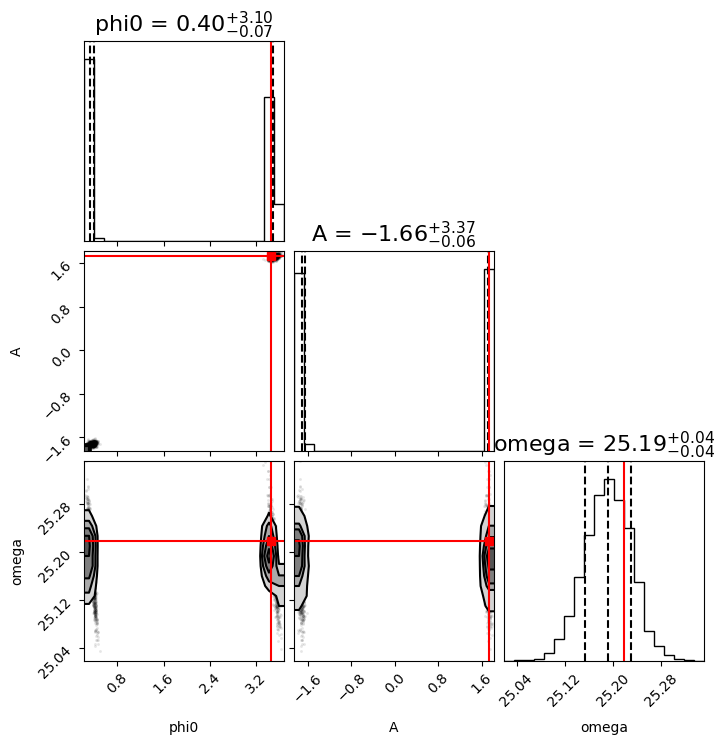


---------------------- Round: 2 ----------------------


Epoch 0: Train, Loglike in nats: -25.459032: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 0.716796: 100%|█| 256/256 [00:00<00:00, 1351.22it/s]
Epoch 1: Train, Loglike in nats: 1.816165: 100%|█| 2304/2304 [00:00<00:00, 3
- Val, Loglike in nats: 2.938455: 100%|█| 256/256 [00:00<00:00, 6964.07it/s]
Epoch 2: Train, Loglike in nats: 3.767795: 100%|█| 2304/2304 [00:00<00:00, 3
- Val, Loglike in nats: 4.019073: 100%|█| 256/256 [00:00<00:00, 7134.31it/s]
Epoch 3: Train, Loglike in nats: 3.963702: 100%|█| 2304/2304 [00:00<00:00, 3
- Val, Loglike in nats: 3.872475: 100%|█| 256/256 [00:00<00:00, 7504.43it/s]
Epoch 4: Train, Loglike in nats: 4.032058: 100%|█| 2304/2304 [00:00<00:00, 3
- Val, Loglike in nats: 4.027811: 100%|█| 256/256 [00:00<00:00, 7622.49it/s]
Epoch 5: Train, Loglike in nats: 4.110664: 100%|█| 2304/2304 [00:00<00:00, 3
- Val, Loglike in nats: 4.155464: 100%|█| 256/256 [00:00<00:00, 7589.03it/s]
Epoch 6: Train, Loglike in nats: 3.645802: 100%|█| 2304/2304 [00:00<00:00, 3

Epoch 53: Train, Loglike in nats: 4.342750: 100%|█| 2304/2304 [00:00<00:00, 
- Val, Loglike in nats: 4.482338: 100%|█| 256/256 [00:00<00:00, 7395.17it/s]
Epoch 54: Train, Loglike in nats: 4.363355: 100%|█| 2304/2304 [00:00<00:00, 
- Val, Loglike in nats: 4.321406: 100%|█| 256/256 [00:00<00:00, 7216.39it/s]
Epoch 55: Train, Loglike in nats: 4.389521: 100%|█| 2304/2304 [00:00<00:00, 
- Val, Loglike in nats: 4.506277: 100%|█| 256/256 [00:00<00:00, 7238.53it/s]
Epoch 56: Train, Loglike in nats: 4.442504: 100%|█| 2304/2304 [00:00<00:00, 
- Val, Loglike in nats: 4.441913: 100%|█| 256/256 [00:00<00:00, 6860.18it/s]
Epoch 57: Train, Loglike in nats: 4.446343: 100%|█| 2304/2304 [00:00<00:00, 
- Val, Loglike in nats: 4.528080: 100%|█| 256/256 [00:00<00:00, 6780.04it/s]
Epoch 58: Train, Loglike in nats: 4.398529: 100%|█| 2304/2304 [00:00<00:00, 
- Val, Loglike in nats: 4.333248: 100%|█| 256/256 [00:00<00:00, 7196.03it/s]
Epoch 59: Train, Loglike in nats: 4.094214: 100%|█| 2304/2304 [00:00<00:00, 

Epoch 106: Train, Loglike in nats: 4.551825: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.550610: 100%|█| 256/256 [00:00<00:00, 7086.70it/s]
Epoch 107: Train, Loglike in nats: 4.387917: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.460163: 100%|█| 256/256 [00:00<00:00, 7424.62it/s]
Epoch 108: Train, Loglike in nats: 4.390234: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.568196: 100%|█| 256/256 [00:00<00:00, 7318.70it/s]
Epoch 109: Train, Loglike in nats: 4.547569: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.484544: 100%|█| 256/256 [00:00<00:00, 7530.96it/s]
Epoch 110: Train, Loglike in nats: 4.574683: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.680196: 100%|█| 256/256 [00:00<00:00, 7685.39it/s]
Epoch 111: Train, Loglike in nats: 4.556639: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.572621: 100%|█| 256/256 [00:00<00:00, 7163.05it/s]
Epoch 112: Train, Loglike in nats: 4.444817: 100%|█| 2304/2304 [00:00<00:00,

Epoch 159: Train, Loglike in nats: 4.617407: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.748337: 100%|█| 256/256 [00:00<00:00, 7138.05it/s]
Epoch 160: Train, Loglike in nats: 4.683209: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.714194: 100%|█| 256/256 [00:00<00:00, 7395.27it/s]
Epoch 161: Train, Loglike in nats: 4.758719: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.775281: 100%|█| 256/256 [00:00<00:00, 7218.77it/s]
Epoch 162: Train, Loglike in nats: 4.698996: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.720401: 100%|█| 256/256 [00:00<00:00, 7337.36it/s]
Epoch 163: Train, Loglike in nats: 4.685947: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.656868: 100%|█| 256/256 [00:00<00:00, 7658.48it/s]
Epoch 164: Train, Loglike in nats: 4.625983: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.719793: 100%|█| 256/256 [00:00<00:00, 7166.21it/s]
Epoch 165: Train, Loglike in nats: 4.623974: 100%|█| 2304/2304 [00:00<00:00,

Epoch 212: Train, Loglike in nats: 4.791015: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.843431: 100%|█| 256/256 [00:00<00:00, 6860.31it/s]
Epoch 213: Train, Loglike in nats: 4.828598: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.838082: 100%|█| 256/256 [00:00<00:00, 7258.30it/s]
Epoch 214: Train, Loglike in nats: 4.775691: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.769201: 100%|█| 256/256 [00:00<00:00, 7301.78it/s]
Epoch 215: Train, Loglike in nats: 4.811089: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.845944: 100%|█| 256/256 [00:00<00:00, 7051.38it/s]
Epoch 216: Train, Loglike in nats: 4.803718: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.749101: 100%|█| 256/256 [00:00<00:00, 7175.88it/s]
Epoch 217: Train, Loglike in nats: 4.814103: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.904918: 100%|█| 256/256 [00:00<00:00, 7270.44it/s]
Epoch 218: Train, Loglike in nats: 4.810892: 100%|█| 2304/2304 [00:00<00:00,

Epoch 265: Train, Loglike in nats: 4.872549: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.920706: 100%|█| 256/256 [00:00<00:00, 6733.99it/s]
Epoch 266: Train, Loglike in nats: 4.873785: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.993923: 100%|█| 256/256 [00:00<00:00, 7380.94it/s]
Epoch 267: Train, Loglike in nats: 4.878537: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.871083: 100%|█| 256/256 [00:00<00:00, 7297.61it/s]
Epoch 268: Train, Loglike in nats: 4.872050: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.880050: 100%|█| 256/256 [00:00<00:00, 6932.20it/s]
Epoch 269: Train, Loglike in nats: 4.860022: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.914714: 100%|█| 256/256 [00:00<00:00, 6968.05it/s]
Epoch 270: Train, Loglike in nats: 4.867594: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.940704: 100%|█| 256/256 [00:00<00:00, 6755.86it/s]
Epoch 271: Train, Loglike in nats: 4.877998: 100%|█| 2304/2304 [00:00<00:00,

Generating simulations


256it [00:00, 2977.96it/s]


Effective sample size for current/all rounds 981.6/1855.7


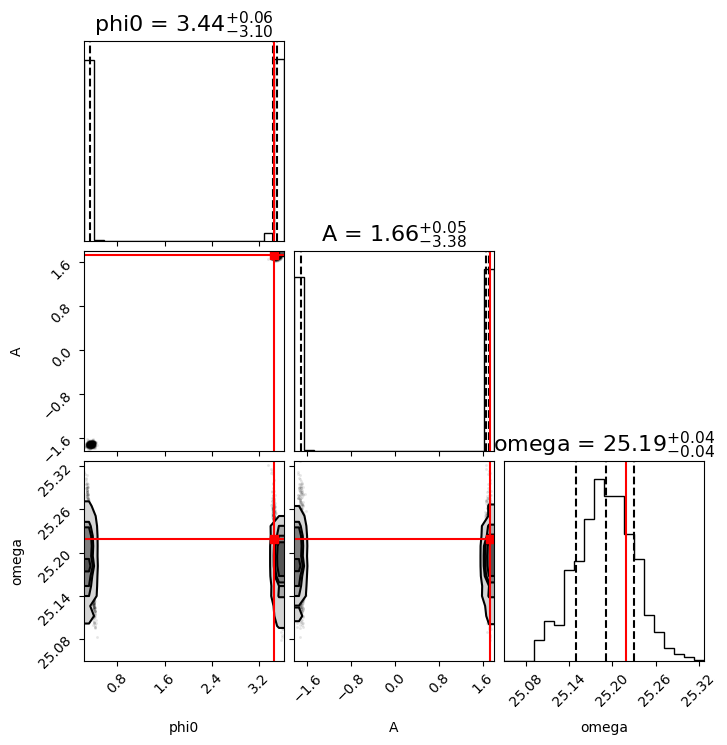


---------------------- Round: 3 ----------------------


Epoch 0: Train, Loglike in nats: -2.254916: 100%|█| 2304/2304 [00:00<00:00, 
- Val, Loglike in nats: 3.607208: 100%|█| 256/256 [00:00<00:00, 1334.22it/s]
Epoch 1: Train, Loglike in nats: 3.961391: 100%|█| 2304/2304 [00:00<00:00, 3
- Val, Loglike in nats: 4.249711: 100%|█| 256/256 [00:00<00:00, 6990.96it/s]
Epoch 2: Train, Loglike in nats: 4.261970: 100%|█| 2304/2304 [00:00<00:00, 3
- Val, Loglike in nats: 4.421974: 100%|█| 256/256 [00:00<00:00, 7016.22it/s]
Epoch 3: Train, Loglike in nats: 4.304015: 100%|█| 2304/2304 [00:00<00:00, 3
- Val, Loglike in nats: 4.360326: 100%|█| 256/256 [00:00<00:00, 7141.28it/s]
Epoch 4: Train, Loglike in nats: 4.237622: 100%|█| 2304/2304 [00:00<00:00, 3
- Val, Loglike in nats: 4.493383: 100%|█| 256/256 [00:00<00:00, 7184.57it/s]
Epoch 5: Train, Loglike in nats: 4.404403: 100%|█| 2304/2304 [00:00<00:00, 3
- Val, Loglike in nats: 4.459258: 100%|█| 256/256 [00:00<00:00, 6830.51it/s]
Epoch 6: Train, Loglike in nats: 4.350708: 100%|█| 2304/2304 [00:00<00:00, 3

Epoch 53: Train, Loglike in nats: 4.460400: 100%|█| 2304/2304 [00:00<00:00, 
- Val, Loglike in nats: 4.672035: 100%|█| 256/256 [00:00<00:00, 7438.20it/s]
Epoch 54: Train, Loglike in nats: 4.339007: 100%|█| 2304/2304 [00:00<00:00, 
- Val, Loglike in nats: 4.002027: 100%|█| 256/256 [00:00<00:00, 6945.16it/s]
Epoch 55: Train, Loglike in nats: 4.277437: 100%|█| 2304/2304 [00:00<00:00, 
- Val, Loglike in nats: 4.693196: 100%|█| 256/256 [00:00<00:00, 7248.06it/s]
Epoch 56: Train, Loglike in nats: 4.443362: 100%|█| 2304/2304 [00:00<00:00, 
- Val, Loglike in nats: 4.625434: 100%|█| 256/256 [00:00<00:00, 7293.85it/s]
Epoch 57: Train, Loglike in nats: 4.621117: 100%|█| 2304/2304 [00:00<00:00, 
- Val, Loglike in nats: 4.820796: 100%|█| 256/256 [00:00<00:00, 7194.25it/s]
Epoch 58: Train, Loglike in nats: 4.700033: 100%|█| 2304/2304 [00:00<00:00, 
- Val, Loglike in nats: 4.580562: 100%|█| 256/256 [00:00<00:00, 7323.30it/s]
Epoch 59: Train, Loglike in nats: 4.378896: 100%|█| 2304/2304 [00:00<00:00, 

Epoch 106: Train, Loglike in nats: 4.739383: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.662352: 100%|█| 256/256 [00:00<00:00, 7214.89it/s]
Epoch 107: Train, Loglike in nats: 4.663712: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.730576: 100%|█| 256/256 [00:00<00:00, 7186.11it/s]
Epoch 108: Train, Loglike in nats: 4.685017: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.662242: 100%|█| 256/256 [00:00<00:00, 7161.81it/s]
Epoch 109: Train, Loglike in nats: 4.420206: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.799919: 100%|█| 256/256 [00:00<00:00, 7222.85it/s]
Epoch 110: Train, Loglike in nats: 4.586950: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.839162: 100%|█| 256/256 [00:00<00:00, 6641.77it/s]
Epoch 111: Train, Loglike in nats: 4.687782: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.866652: 100%|█| 256/256 [00:00<00:00, 7072.79it/s]
Epoch 112: Train, Loglike in nats: 4.816356: 100%|█| 2304/2304 [00:00<00:00,

Epoch 159: Train, Loglike in nats: 4.769931: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.942445: 100%|█| 256/256 [00:00<00:00, 6408.49it/s]
Epoch 160: Train, Loglike in nats: 4.880798: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.913004: 100%|█| 256/256 [00:00<00:00, 7519.89it/s]
Epoch 161: Train, Loglike in nats: 4.930751: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.947358: 100%|█| 256/256 [00:00<00:00, 7085.35it/s]
Epoch 162: Train, Loglike in nats: 4.842791: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.882313: 100%|█| 256/256 [00:00<00:00, 7413.40it/s]
Epoch 163: Train, Loglike in nats: 4.823536: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.852108: 100%|█| 256/256 [00:00<00:00, 7592.84it/s]
Epoch 164: Train, Loglike in nats: 4.855254: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.936172: 100%|█| 256/256 [00:00<00:00, 7433.62it/s]
Epoch 165: Train, Loglike in nats: 4.891049: 100%|█| 2304/2304 [00:00<00:00,

Epoch 212: Train, Loglike in nats: 4.943468: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.998631: 100%|█| 256/256 [00:00<00:00, 7383.53it/s]
Epoch 213: Train, Loglike in nats: 4.959769: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 5.023635: 100%|█| 256/256 [00:00<00:00, 7492.13it/s]
Epoch 214: Train, Loglike in nats: 4.937681: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.956433: 100%|█| 256/256 [00:00<00:00, 7380.73it/s]
Epoch 215: Train, Loglike in nats: 4.959364: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 5.026244: 100%|█| 256/256 [00:00<00:00, 6990.14it/s]
Epoch 216: Train, Loglike in nats: 4.938967: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 4.952768: 100%|█| 256/256 [00:00<00:00, 7575.97it/s]
Epoch 217: Train, Loglike in nats: 4.959960: 100%|█| 2304/2304 [00:00<00:00,
- Val, Loglike in nats: 5.049692: 100%|█| 256/256 [00:00<00:00, 7559.86it/s]
Epoch 218: Train, Loglike in nats: 4.943532: 100%|█| 2304/2304 [00:00<00:00,

early stopping, loading state dict from epoch 202
Generating simulations


256it [00:00, 3215.27it/s]


Effective sample size for current/all rounds 321.0/2176.7


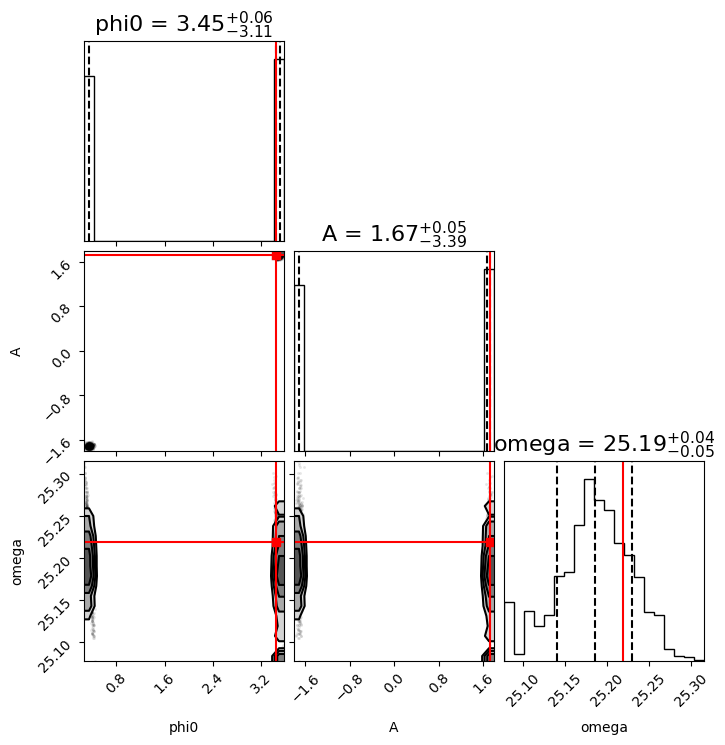

Early stop: Surrogate posterior did not improve for this round


In [9]:
engine.fit(
    x_obs=x_obs,
    y_true=y_true,
    n_sims=2560,                 # N = 5120 per round
    n_rounds=5,                  # Max 5 rounds. (also see early_stop_traing)
    n_epochs=300,
    batch_size=128,
    lr=0.0005,
    early_stop_train=True,       # If sampling efficiency is reduced for this round, stop and revert to previous round
    early_stop_patience=50,      # Within a round, wait this many epochs before stopping training
    noise=np.array([0.1]*50)     # assume homogeneous noise; used for importance sampling
)

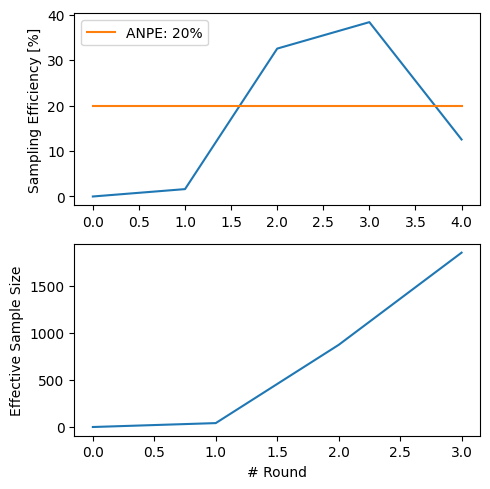

In [13]:
plt.rcParams['figure.dpi']=100
plt.figure(figsize=(5,5))
plt.subplot(211)
plt.plot(np.array(engine.neff)/2560*100)
plt.plot([0,4],[20,20],label='ANPE: 20%')
plt.legend()
plt.ylabel('Sampling Efficiency [%]')
plt.subplot(212)
plt.plot([np.sum(engine.neff[:i+1]) for i in range(4)])
plt.ylabel('Effective Sample Size')
plt.xlabel('# Round')
plt.tight_layout()

As we see, after the 3rd round of training the sampling efficiency is as high as 40%, meaning the NDE posterior is nearly the true posterior. In comparison, for ANPE we used more training samples and ended up with a lower sampling efficiency of 20%, showcasing the efficacy of SNPE (active learning).

As expected, the 4th round of training degraded the result due to the use of NLL loss (see paper for details). Therefore, the network state is automatically reverted to the 3rd round. Note that every training round contributed to the final effective sample.

To generate more effective posterior samples, let us draw 10000 more samples from the 3nd round NDE. The first corner plot is the (unweighted) NDE surrogate posterior. The second one shows the importance reweighted posterior, which is asymptotically exact

In [14]:
engine.best_params

'test/2/266.pth'

surrogate posterior


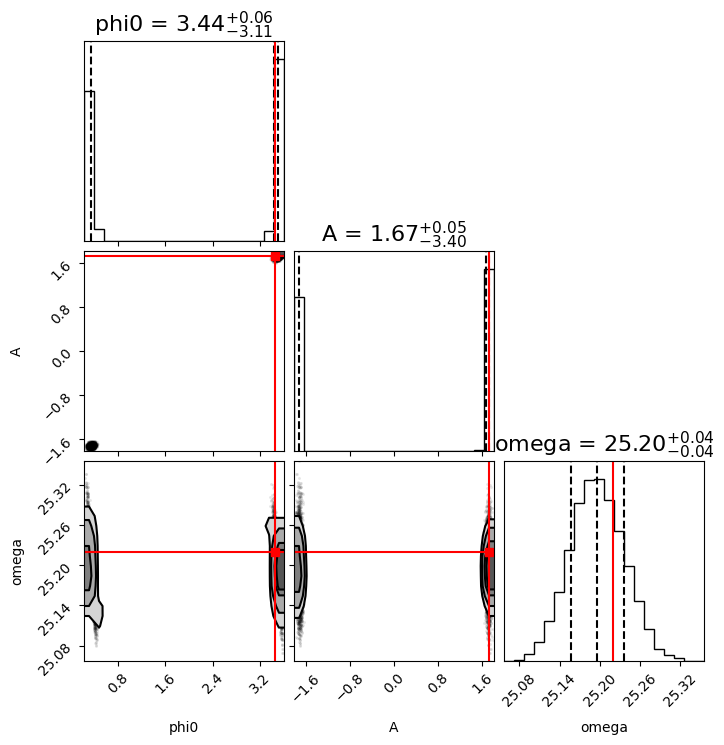

Generating simulations


1000it [00:00, 2913.62it/s]


Effective Sample Size = 3757.0
Sampling efficiency = 37.6%


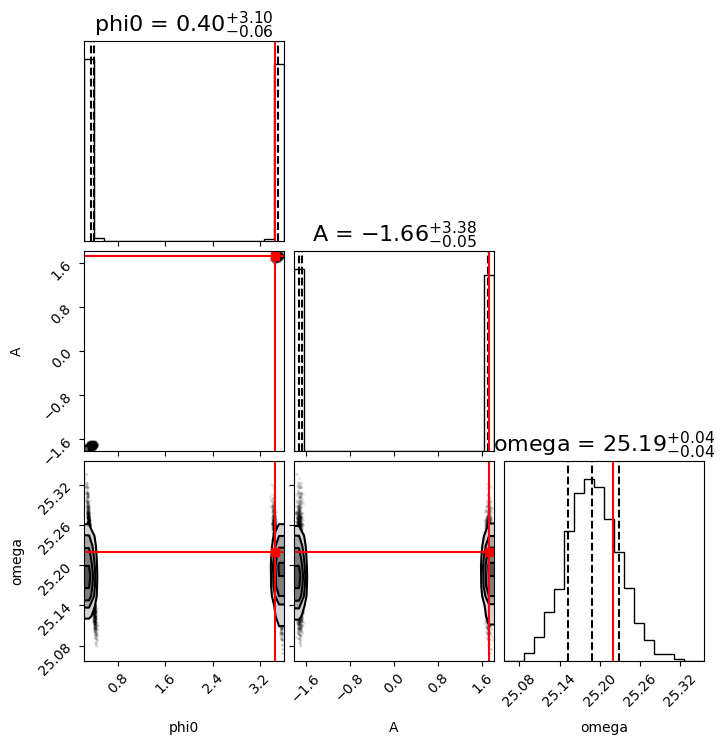

In [16]:
y_pred, weights = engine.predict(x_obs, x_err=np.array([0.1]*50),y_true=y_true, n_samples=10000, corner=True, corner_reweight=True,seed=0)